# Probabilistic Forecasting with `sktime`

### Overview of this notebook

* quick start - probabilistic forecasting
* disambiguation - types of probabilistic forecasts
* details: probabilistic forecasting interfaces
* metrics for, and evaluation of probabilistic forecasts
* advanced composition: pipelines, tuning, reduction
* extender guide

In [1]:
import warnings

warnings.simplefilter("ignore")

---

### Use case motivation

* want to **predict energy demand hourly** next 24 hours
* know that energy demand **fluctuates**
* want a plausible range, "on 95% of similar days", lower/upper

<img src="imgs/pt_n_proba_fcst.png" alt="placeholder" width="100%">

Business value of probabilistic forecasting:

* knowing **range of plausible outcomes** - is a "catastropic scenario" likely?
* knowing **"certainty" of mid scenario** (according to algorithm)
* basis for **scenario analysis** low/mid/high etc

Bit of mathematical complexity, but **not an academic exercise!**

---
### Quick Start - Probabilistic Forecasting with `sktime`

... works exactly like the basic forecasting workflow, replace `predict` by a probabilistic method!

In [2]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster


# step 1: data specification
y = load_airline()
# step 2: specifying forecasting horizon
fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# step 3: specifying the forecasting algorithm
forecaster = ThetaForecaster(sp=12)
# step 4: fitting the forecaster
forecaster.fit(y, fh=fh)
# step 5: querying predictions
y_pred = forecaster.predict()

# for probabilistic forecasting:
#   call a probabilistic forecasting method after or instead of step 5
y_pred_int = forecaster.predict_interval(coverage=0.9)
y_pred_int

Number of airline passengers            
                                 0.9            
                               lower       upper
1961-01                   418.280121  464.281951
1961-02                   402.215881  456.888055
1961-03                   459.966113  522.110500
1961-04                   442.589309  511.399214
1961-05                   443.525027  518.409480
1961-06                   506.585814  587.087737
1961-07                   561.496768  647.248956
1961-08                   557.363322  648.062363
1961-09                   477.658056  573.047752
1961-10                   407.915090  507.775355
1961-11                   346.942924  451.082016
1961-12                   394.708221  502.957142

for illustration, plotting actuals and prediction intervals:

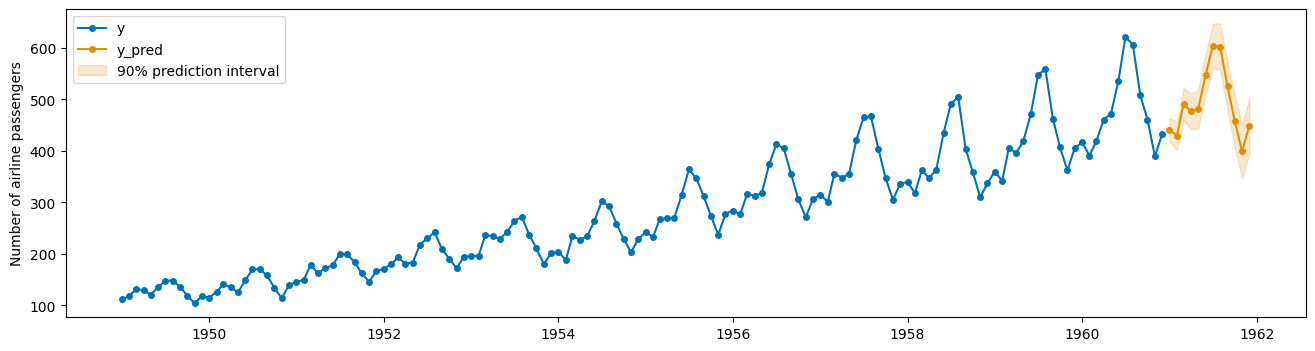

In [3]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_int
)

ax.legend();

#### Different types of probabilistic predictions - stylized selection

<img src="imgs/pred_proba_types.jpg" alt="placeholder" width="100%">

**probabilistic forecasting methods in `sktime`**:

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* forecast variance     - `predict_var(fh=None, X=None, cov=False)`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

To check which forecasters in `sktime` support probabilistic forecasting:

use `registry.all_estimators`, search for estimators with `capability:pred_int` tag (value `True`).

For composites such as pipelines, the tag means that logic is implemented if (some or all) components support it.

For in-sample (proba) capability, use tag `capability:pred_int:insample` (not all proba forecasters have this)

In [4]:
from sktime.registry import all_estimators

# list all probabilistic forecasters
all_estimators(
    "forecaster",
    as_dataframe=True,
    filter_tags="capability:pred_int",
)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
2,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,BATS,<class 'sktime.forecasting.bats.BATS'>
5,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
6,BoxCoxBiasAdjustedForecaster,<class 'sktime.forecasting.boxcox_bias_adjuste...
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
9,DartsLinearRegressionModel,<class 'sktime.forecasting.darts.DartsLinearRe...


---
### Probabilistic forecasting interfaces in `sktime` 

This section:

* walkthrough of probabilistic predict methods
* multivariate and hierarchical data

All forecasters with tag `capability:pred_int` provide the following:

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* forecast variance     - `predict_var(fh=None, X=None, cov=False)`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

Generalities:

* methods do not change state, multiple can be called
* `fh` is optional, if passed late
* exogeneous data `X` can be passed

#### preparing a fitted forecaster for demo

In [5]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

# until fit, identical with the simple workflow
y = load_airline()

fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=fh)

ThetaForecaster(sp=12)

---

#### `predict_interval` - interval predictions

**"we predict that value in row falls between bottom/upper with 90% chance"**

**Input:**\
`coverage`, float or list of floats, default=`0.9`\
= nominal coverage(s) of the prediction interval(s) queried

**Output:** `pandas.DataFrame`\
Row index is `fh`\
Column has multi-index:\
1st level = variable name from y in fit\
2nd level = coverage fractions in `coverage`\
3rd level = string "lower" or "upper"

Entries = forecasts of lower/upper interval at nominal coverage in 2nd lvl, for var in 1st lvl, for time in row

In [6]:
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Number of airline passengers            
                                 0.9            
                               lower       upper
1961-01                   418.280121  464.281951
1961-02                   402.215881  456.888055
1961-03                   459.966113  522.110500
1961-04                   442.589309  511.399214
1961-05                   443.525027  518.409480
1961-06                   506.585814  587.087737
1961-07                   561.496768  647.248956
1961-08                   557.363322  648.062363
1961-09                   477.658056  573.047752
1961-10                   407.915090  507.775355
1961-11                   346.942924  451.082016
1961-12                   394.708221  502.957142

<img src="imgs/proba_int_fcst_expl.png" alt="placeholder" width="100%">

pretty-plotting the predictive interval forecasts:

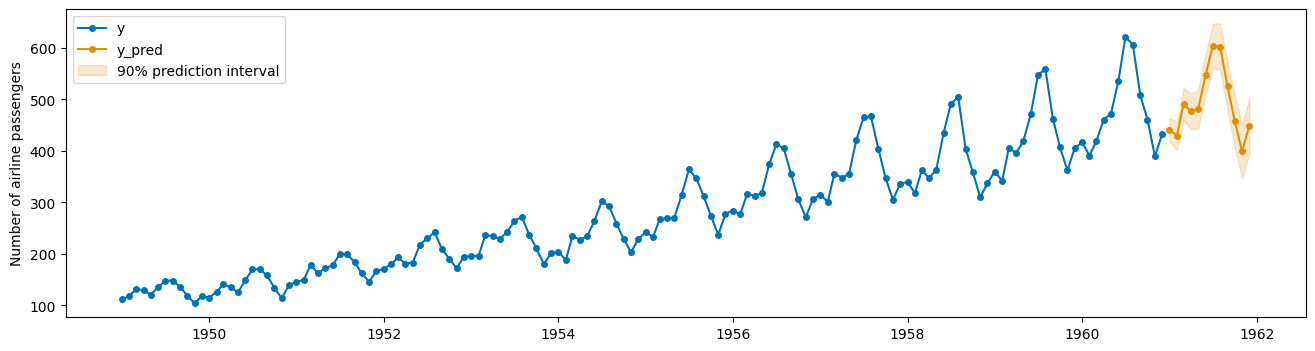

In [7]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints
)

ax.legend();

multiple (nominal) coverages:

In [8]:
coverage = [0.5, 0.9, 0.95]
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Number of airline passengers                                      \
                                0.50                    0.90               
                               lower       upper       lower       upper   
1961-01                   431.849266  450.712806  418.280121  464.281951   
1961-02                   418.342514  440.761421  402.215881  456.888055   
1961-03                   478.296822  503.779790  459.966113  522.110500   
1961-04                   462.886144  491.102379  442.589309  511.399214   
1961-05                   465.613670  496.320837  443.525027  518.409480   
1961-06                   530.331440  563.342111  506.585814  587.087737   
1961-07                   586.791063  621.954661  561.496768  647.248956   
1961-08                   584.116789  621.308897  557.363322  648.062363   
1961-09                   505.795123  544.910684  477.658056  573.047752   
1961-10                   437.370840  478.319605  407.915090  507.775355   
1961-11                   377.660798  420.364142  346.942924  451.082016   
1961-12                   426.638370  471.026993  394.708221  502.957142   

                                 
               0.95              
              lower       upper  
1961-01  413.873755  468.688317  
1961-02  396.979011  462.124925  
1961-03  454.013504  528.063109  
1961-04  435.998232  517.990291  
1961-05  436.352089  525.582418  
1961-06  498.874797  594.798754  
1961-07  553.282845  655.462879  
1961-08  548.675556  656.750129  
1961-09  468.520987  582.184821  
1961-10  398.349800  517.340645  
1961-11  336.967779  461.057161  
1961-12  384.339409  513.325954

`predict_interval` output spec:

`pandas.DataFrame`\
Row index is as for `X_new`\
Column has multi-index:\
1st level = variable names from `y` in fit\
2nd level = coverage fractions in `coverage`\
3rd level = string `"lower"` or `"upper"`

Entries = interval prediction of lower/upper interval at nominal coverage in 2nd lvl, for var in 1st lvl, for data index in row

---

#### `predict_quantiles` - quantile forecasts

**"we predict the 5%, 50%, 95% quantile points for the forecast to be here"**

**Input**:\
`alpha`, float or list of floats, default = `[0.1, 0.9]`\
= quantile points at which quantiles are queried

**Output:** `pandas.DataFrame`\
Row index is `fh`\
Column has multi-index:\
1st level = variable name from y in fit\
2nd level = quantile points in `alpha`

Entries = forecasts of quantiles at quantile point in 2nd lvl, for var in 1st lvl, for time in row

In [9]:
alpha = [0.05, 0.25, 0.5, 0.75, 0.95]
y_pred_quantiles = forecaster.predict_quantiles(alpha=alpha)
y_pred_quantiles

Number of airline passengers                                      \
                                0.05        0.25        0.50        0.75   
1961-01                   418.280121  431.849266  441.281036  450.712806   
1961-02                   402.215881  418.342514  429.551968  440.761421   
1961-03                   459.966113  478.296822  491.038306  503.779790   
1961-04                   442.589309  462.886144  476.994261  491.102379   
1961-05                   443.525027  465.613670  480.967253  496.320837   
1961-06                   506.585814  530.331440  546.836776  563.342111   
1961-07                   561.496768  586.791063  604.372862  621.954661   
1961-08                   557.363322  584.116789  602.712843  621.308897   
1961-09                   477.658056  505.795123  525.352904  544.910684   
1961-10                   407.915090  437.370840  457.845222  478.319605   
1961-11                   346.942924  377.660798  399.012470  420.364142   
1961-12                   394.708221  426.638370  448.832681  471.026993   

                     
               0.95  
1961-01  464.281951  
1961-02  456.888055  
1961-03  522.110500  
1961-04  511.399214  
1961-05  518.409480  
1961-06  587.087737  
1961-07  647.248956  
1961-08  648.062363  
1961-09  573.047752  
1961-10  507.775355  
1961-11  451.082016  
1961-12  502.957142

<img src="imgs/proba_quant_fcst_expl.png" alt="placeholder" width="100%">

pretty-plotting the quantile interval forecasts:

In [10]:
import matplotlib.pyplot as plt

colors = plt.cm.viridis([0.3, 0.5, 0.55, 0.6, 0.65, 0.7])

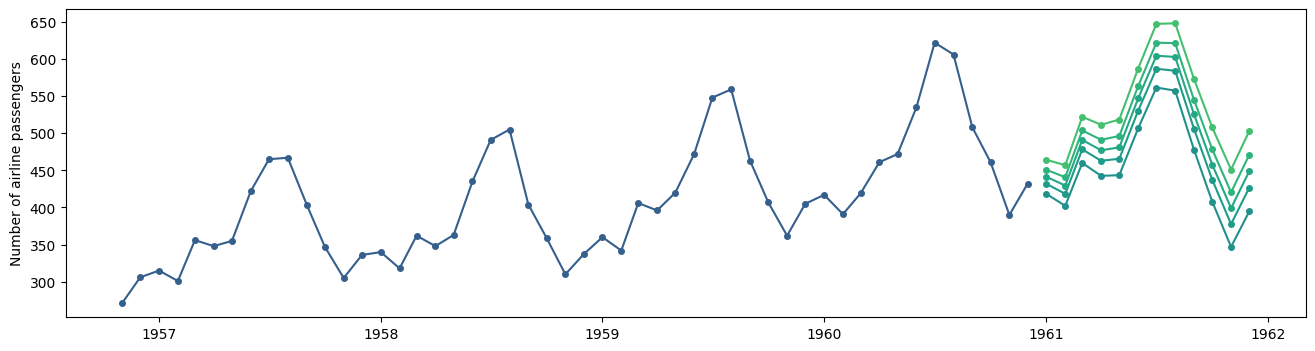

In [11]:
from sktime.utils import plotting

columns = [y_pred_quantiles[i] for i in y_pred_quantiles.columns]
fig, ax = plotting.plot_series(y[-50:], *columns, colors=colors)

`predict_quantiles` output spec:

`pandas.DataFrame`\
Row index is same as `X_new`\
Column has multi-index:\
1st level = variable names from `y` in `fit`\
2nd level = quantile points in `alpha`

Entries = quantiles prediction at quantile point in 2nd lvl, for var in 1st lvl, for data index in row

In [12]:
y_pred_quantiles

Number of airline passengers                                      \
                                0.05        0.25        0.50        0.75   
1961-01                   418.280121  431.849266  441.281036  450.712806   
1961-02                   402.215881  418.342514  429.551968  440.761421   
1961-03                   459.966113  478.296822  491.038306  503.779790   
1961-04                   442.589309  462.886144  476.994261  491.102379   
1961-05                   443.525027  465.613670  480.967253  496.320837   
1961-06                   506.585814  530.331440  546.836776  563.342111   
1961-07                   561.496768  586.791063  604.372862  621.954661   
1961-08                   557.363322  584.116789  602.712843  621.308897   
1961-09                   477.658056  505.795123  525.352904  544.910684   
1961-10                   407.915090  437.370840  457.845222  478.319605   
1961-11                   346.942924  377.660798  399.012470  420.364142   
1961-12                   394.708221  426.638370  448.832681  471.026993   

                     
               0.95  
1961-01  464.281951  
1961-02  456.888055  
1961-03  522.110500  
1961-04  511.399214  
1961-05  518.409480  
1961-06  587.087737  
1961-07  647.248956  
1961-08  648.062363  
1961-09  573.047752  
1961-10  507.775355  
1961-11  451.082016  
1961-12  502.957142

---

#### `predict_var` - (mean-)variance forecasts

**Inputs:**\
`cov`, boolean, default=False\
whether covariance forecasts should also be returned (not all estimators support this)

**Output:** `pandas.DataFrame`, for cov=False:\
Row index is `fh`\
Column is equal to column index of `y` (variables)

Entries = variance forecast for variable in col, for time in row

In [13]:
y_pred_mean = forecaster.predict()  # this is the normal predict method
y_pred_variance = forecaster.predict_var()  # variance prediction
y_pred_variance

,Number of airline passengers
1961-01,195.540049
1961-02,276.196509
1961-03,356.852968
1961-04,437.509428
1961-05,518.165887
1961-06,598.822347
1961-07,679.478807
1961-08,760.135266
1961-09,840.791726
1961-10,921.448185


---

#### `predict_proba` - distribution forecasts aka "full" probabilistic forecasts

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\

Output: `skpro` `Distribution` object

`y_pred_proba` is an `skpro` distribution - it has index and columns like `pd.DataFrame`

"we predict that true labels are distributed according to `y_pred_proba`"

(here: distribution marginal by row/columns)

In [14]:
y_pred_proba = forecaster.predict_proba()
type(y_pred_proba)

skpro.distributions.normal.Normal

In [15]:
# first five rows converted to DataFrame of distribution parameters
# (works only for parametric forecast distributions)
y_pred_proba.head().to_df()

Number of airline passengers           
                                  mu      sigma
1961-01                   441.281036  13.983564
1961-02                   429.551968  16.619161
1961-03                   491.038306  18.890552
1961-04                   476.994261  20.916726
1961-05                   480.967253  22.763257

In [16]:
y_pred_proba.head()

Normal(columns=Index(['Number of airline passengers'], dtype='object'),
       index=PeriodIndex(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05'], dtype='period[M]'),
       mu=array([[441.28103617],
       [429.55196778],
       [491.03830627],
       [476.99426135],
       [480.96725348]]),
       sigma=array([[13.98356353],
       [16.61916089],
       [18.89055235],
       [20.91672603],
       [22.7632574 ]]))

pretty printing distribution:

(<Figure size 640x480 with 5 Axes>,
 array([<Axes: title={'center': 'Number of airline passengers'}, ylabel='1961-01'>,
        <Axes: ylabel='1961-02'>, <Axes: ylabel='1961-03'>,
        <Axes: ylabel='1961-04'>, <Axes: ylabel='1961-05'>], dtype=object))

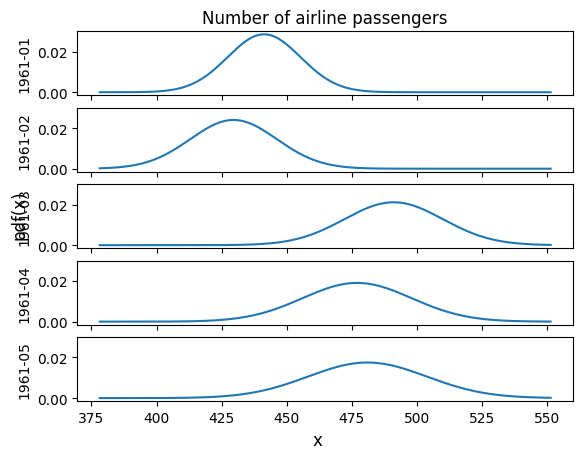

In [17]:
y_pred_proba.head().plot()

(<Figure size 640x480 with 5 Axes>,
 array([<Axes: title={'center': 'Number of airline passengers'}, ylabel='1961-01'>,
        <Axes: ylabel='1961-02'>, <Axes: ylabel='1961-03'>,
        <Axes: ylabel='1961-04'>, <Axes: ylabel='1961-05'>], dtype=object))

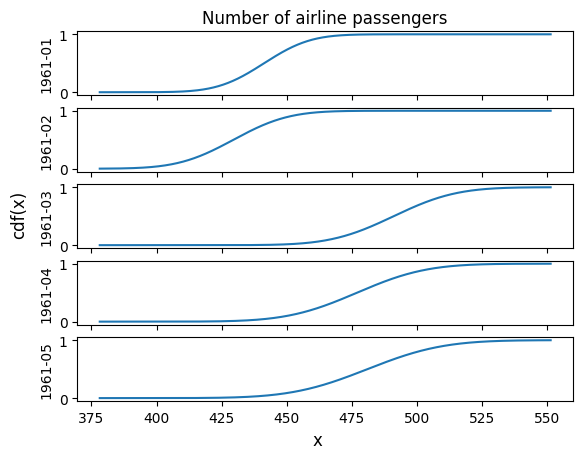

In [18]:
y_pred_proba.head().plot("cdf")

In [19]:
# compare the parameter data frame with the plot
y_pred_proba.head().to_df()  # mu = mean, sigma = std deviation

Number of airline passengers           
                                  mu      sigma
1961-01                   441.281036  13.983564
1961-02                   429.551968  16.619161
1961-03                   491.038306  18.890552
1961-04                   476.994261  20.916726
1961-05                   480.967253  22.763257

In [20]:
# obtaining quantiles
y_pred_proba.head().quantile([0.1, 0.9])

Number of airline passengers            
                                 0.1         0.9
1961-01                   423.360378  459.201694
1961-02                   408.253656  450.850279
1961-03                   466.829089  515.247523
1961-04                   450.188398  503.800124
1961-05                   451.794965  510.139542

`skpro` distribution objects are pandas-like

In [21]:
y_pred_proba.shape

(12, 1)

In [22]:
y_pred_proba.index  # same index as from predict

PeriodIndex(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12'],
            dtype='period[M]')

distribution objects have unified API with methods such as:

* `sample` - sample from distribution (row-wise marginals)
* `mean` - expected value
* `var` - variance

In [23]:
y_pred_proba.sample().head()

,Number of airline passengers
1961-01,426.195497
1961-02,417.947596
1961-03,483.278568
1961-04,445.449226
1961-05,487.388820


In [24]:
y_pred_proba.mean().head()

,Number of airline passengers
1961-01,441.281036
1961-02,429.551968
1961-03,491.038306
1961-04,476.994261
1961-05,480.967253


In [25]:
y_pred_proba.var().head()

,Number of airline passengers
1961-01,195.540049
1961-02,276.196509
1961-03,356.852968
1961-04,437.509428
1961-05,518.165887


more details on `skpro` distributions in the advanced tutorial!

---

##### a note on consistency of methods

Outputs of `predict_interval`, `predict_quantiles`, `predict_var`, `predict_proba` are *typically* but not *necessarily* consistent with each other!

Consistency is weak interface requirement but not strictly enforced.

#### Probabilistic forecasting for multivariate and hierarchical data

In [26]:
from sktime.datasets import load_longley

_, y = load_longley()
y.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


multivariate data: first column index for different variables

In [27]:
from sktime.datasets import load_longley
from sktime.forecasting.var import VAR

mv_forecaster = VAR()

mv_forecaster.fit(y, fh=[1, 2, 3])
mv_forecaster.predict_var()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1963,2.054577,6.505885e+07,349496.724319,206411.766443,87656.385238
1964,2.458700,1.108427e+08,529025.512014,315845.148830,215383.313893
1965,3.799322,1.432371e+08,663790.333183,411656.726839,340666.369241


hierarchical data: probabilistic forecasts per level are row-concatenated with a row hierarchy index

In [28]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.utils._testing.hierarchical import _make_hierarchical

y_hier = _make_hierarchical(hierarchy_levels=(2, 2), max_timepoints=4, min_timepoints=4)
y_hier.head(10)

c0
h0   h1   time                
h0_0 h1_0 2000-01-01  1.468559
          2000-01-02  3.226674
          2000-01-03  2.516491
          2000-01-04  3.013513
     h1_1 2000-01-01  2.626490
          2000-01-02  2.093958
          2000-01-03  3.250056
          2000-01-04  1.724119
h0_1 h1_0 2000-01-01  2.487034
          2000-01-02  2.657619

In [29]:
forecaster = ThetaForecaster()
forecaster.fit(y_hier, fh=[1, 2, 3])
y_pred = forecaster.predict_interval()
y_pred.head(10)

c0          
                           0.9          
                         lower     upper
h0   h1   time                          
h0_0 h1_0 2000-01-05  2.248179  4.826781
          2000-01-06  2.444413  5.023015
          2000-01-07  2.640647  5.219249
     h1_1 2000-01-05  0.943801  3.127706
          2000-01-06  0.866250  3.050156
          2000-01-07  0.788700  2.972605
h0_1 h1_0 2000-01-05  2.768022  4.286612
          2000-01-06  2.738043  4.597928
          2000-01-07  2.734848  4.882458
     h1_1 2000-01-05  0.754738  5.035363

---
### Metrics for probabilistic forecasts and evaluation


Why metrics & evaluation?

<img src="imgs/trust_me_I_am_an_AI.png" alt="placeholder" width="100%">

jokes aside:

**nominal certainty** $\neq$ **actual certainty**

**nominal coverage** $\neq$ **actual coverage** etc

**we need to evaluate how well the algorithm did!**

<img src="imgs/proba_losses.png" alt="placeholder" width="100%">

General usage pattern same as for `sklearn` metrics:

1. get some actuals and predictions
2. specify the metric - similar to estimator specs
3. plug the actuals and predictions into metric to get metric values

*need to use dedicated metric for probabilistic predictions*

* ground truth: `y_true` samples
* prediction e.g., `y_predict_proba`, `y_predict_interval`
* so, match metric with type of prediction!
    * `metric(y_true: 2D pd.DataFrame, y_pred: proba_prediction_type) -> float`

In [30]:
import numpy as np

from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

y_train = load_airline()[0:24]  # train on 24 months, 1949 and 1950
y_test = load_airline()[24:36]  # ground truth for 12 months in 1951

# try to forecast 12 months ahead, from y_train
fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train, fh=fh)

ThetaForecaster(sp=12)

#### metrics for prediction intervals - example: empirical coverage

In [31]:
pred_int = forecaster.predict_interval(coverage=0.9)
pred_int.head()

Number of airline passengers            
                                 0.9            
                               lower       upper
1951-01                   125.707998  141.744251
1951-02                   135.554586  154.422381
1951-03                   149.921348  171.247998
1951-04                   140.807417  164.337362
1951-05                   127.941097  153.484993

how do we fare in terms of *actual* coverage? Also called empirical coverage.

empirical coverage = percentage of times in the test set where actual value was in the interval

this should be close to nominal coverage for a good forecast.

In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import EmpiricalCoverage

empirical_coverage = EmpiricalCoverage()
empirical_coverage(y_true=y_test, y_pred=pred_int)
# nominal coverage was 90%

0.3333333333333333

(oops, not so good is it?)

#### metrics for predictive quantiles - example: Pinball loss

for predictive quantiles, a common choice is the pinball loss.

**for today's workshop, just accept this is a "good" and common choice. We will revisit in the advanced workshop.**

Definition:

$L_\alpha(y, \widehat{y}) = (y - \hat{y}) \left( \alpha - H(y - \hat{y}) \right)$

where $\alpha\in [0,1]$ is the quantile for which the prediction is made,

and $H$ is the Heaviside function, $H(x) := 0 \text{ if } x < 0,\ 1 \text{ if } x \geq 0$.

Note: same as MAE, but with different weights for under- vs over-prediction - namely, $\alpha$ and $1-\alpha$.

In [ ]:
pred_quantiles = forecaster.predict_quantiles(alpha=[0.1, 0.25, 0.5, 0.75, 0.9])
pred_quantiles.head()

Number of airline passengers                                      \
                                0.10        0.25        0.50        0.75   
1951-01                   127.478978  130.438207  133.726125  137.014043   
1951-02                   137.638269  141.120013  144.988483  148.856953   
1951-03                   152.276577  156.212063  160.584673  164.957283   
1951-04                   143.405969  147.748037  152.572389  157.396741   
1951-05                   130.762062  135.475772  140.713045  145.950318   

                     
               0.90  
1951-01  139.973272  
1951-02  152.338697  
1951-03  168.892768  
1951-04  161.738809  
1951-05  150.664027

In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

pinball_loss = PinballLoss()
pinball_loss(y_true=y_test, y_pred=pred_quantiles)
# this is averaged over all quantiles and time points by default

5.917517291566615

"index-wise" evaluation same as for point prediction metrics:

In [35]:
pinball_loss.evaluate_by_index(y_true=y_test, y_pred=pred_quantiles)

0      4.308602
1      1.410617
2      6.941107
3      3.264743
4     13.527593
5      3.392811
6      6.198473
7      6.088602
8      6.013414
9      5.417999
10     6.470199
11     7.976047
dtype: float64

more about different metric types in the advanced workshop!

#### evaluation by backtesting

remember workshop 1:

* single train/test split problematic
* backtesting is more reliable indicator of performance!

works the same for proba metrics as for point predictions

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

# 1. define data
y = load_airline()

# 2. define splitting/backtesting regime
fh = [1, 2, 3]
cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=72)

# 3. define loss to use
loss = PinballLoss(alpha=[0.3, 0.5, 0.7])
# IMPORTANT for proba forecasts:
# pass alpha here, otherwise default is [0.05, 0.95] 
# same for coverage and other predict_xyz methods
#
# the metric also averages over alpha values and time indices
# default is score_average=True and multi_output="uniform_average", to get a number

forecaster = ThetaForecaster(sp=12)
results = evaluate(
    forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True, scoring=loss
)
results.iloc[:, :5].head()

,test_PinballLoss,fit_time,pred_quantiles_time,len_train_window,cutoff
0,2.564236,0.021176,0.016869,72,1954-12
1,1.894103,0.021339,0.016386,84,1955-12
2,2.195895,0.020302,0.015250,96,1956-12
3,7.428716,0.018811,0.014841,108,1957-12
4,6.229946,0.018931,0.014584,120,1958-12


* each row is one train/test split in the walkforward setting
* first col is the loss on the test fold
* last two columns summarize length of training window, cutoff between train/test

---
### Advanced composition: pipelines, tuning, reduction, adding proba forecasts to any estimator


composition = constructing "composite" estimators out of multiple "component" estimators

* **reduction** = building estimator type A using estimator type B
    * special case: adding proba forecasting capability to non-proba forecaster
    * special case: using proba supervised learner for  proba forecasting
* **pipelining** = chaining estimators, here: transformers to a forecaster
* **tuning** = automated hyper-parameter fitting, usually via internal evaluation loop
    * special case: grid parameter search and random parameter search tuning
    * special case: "Auto-ML", optimizing not just estimator hyper-parameter but also choice of estimator

#### Adding probabilistic forecasts to non-probabilistic forecasters

start with a forecaster that does not produce probabilistic predictions:

In [37]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

my_forecaster = ExponentialSmoothing()

# does the forecaster support probabilistic predictions?
my_forecaster.get_tag("capability:pred_int")

False

adding probabilistic predictions is possible via reduction wrappers:

In [38]:
# NaiveVariance adds intervals & variance via collecting past residuals
from sktime.forecasting.naive import NaiveVariance

# create a composite forecaster like this:
my_forecaster_with_proba = NaiveVariance(my_forecaster)

# does it support probabilistic predictions now?
my_forecaster_with_proba.get_tag("capability:pred_int")

True

In [39]:
my_forecaster_with_proba

NaiveVariance(forecaster=ExponentialSmoothing())

the composite can now be used like any probabilistic forecaster:

In [40]:
y = load_airline()

my_forecaster_with_proba.fit(y, fh=[1, 2, 3])
my_forecaster_with_proba.predict_interval()

Number of airline passengers            
                                 0.9            
                               lower       upper
1961-01                   341.950660  522.049339
1961-02                   319.828426  544.171573
1961-03                   307.334366  556.665632

wrappers of this type - in rough order of complexity

* `NaiveVariance` (a "baseline")
* `SquaringResiduals`
* `ConformalIntervals`
* `EnbPIForecaster`
* `BaggingForecaster`, usable with
    * `STLBootstrapTransformer`
    * `MovingBlockBootstrapTransformer`
    * `SplitterBootstrapTransformer` to use any splitter for bootstrapping
    * `TSBootstrapAdapter` to use any bootstrap algorithm (customizable)

more about proba adder wrappers in the advanced session!

#### Tuning and AutoML 

tuning and autoML with probabilistic forecasters works exactly like with "ordinary" forecasters\
via `ForecastingGridSearchCV`, `ForecastingRandomSearchCV`, `ForecastingOptunaSearchCV`

For tuning probabilistic forecaster:

* wrap a probabilistic forecaster to tune
* use a probabilistic metric or loss function, e.g., `PinballLoss`, `CRPS`

Internally, evaluation will be done using probabilistic metric, via backtesting evaluation.

**important**: to evaluate the tuned estimator, use it in `evaluate` or a separate benchmarking workflow.\
Using internal metric/loss values amounts to in-sample evaluation, which is over-optimistic.

In [41]:
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

# forecaster we want to tune
forecaster = ThetaForecaster()

# parameter grid to search over
param_grid = {"sp": [1, 6, 12]}

# evaluation/backtesting regime for *tuning*
fh = [1, 2, 3]  # fh for tuning regime, does not need to be same as in fit/predict!
cv = SlidingWindowSplitter(window_length=36, fh=fh)
scoring = PinballLoss()

# construct the composite forecaster with grid search compositor
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=param_grid, scoring=scoring, strategy="refit"
)

In [42]:
from sktime.datasets import load_airline

y = load_airline()[:60]

gscv.fit(y, fh=fh)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[1, 2, 3],
                                                 window_length=36),
                        forecaster=ThetaForecaster(),
                        param_grid={'sp': [1, 6, 12]}, scoring=PinballLoss())

inspect hyper-parameter fit obtained by tuning:

In [43]:
gscv.best_params_

{'sp': 12}

obtain predictions:

In [44]:
gscv.predict_interval()

Number of airline passengers            
                                 0.9            
                               lower       upper
1954-01                   190.832917  217.164705
1954-02                   195.638436  226.620354
1954-03                   221.947953  256.967883

for AutoML, use the `MultiplexForecaster` to select among multiple forecasters:

In [45]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster, NaiveVariance

forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y)
gscv.best_params_

{'selected_forecaster': 'naive'}

#### Pipelines with probabilistic forecasters

most proba wrappers and bootstrap algorithms assume no seasonality, trend, stationarity, no missing values ...

so we should deseasonalize, detrend, stationarize before applying proba wrappers

**solution: pipelines**

`sktime` pipelines are compatible with probabilistic forecasters:

* `ForecastingPipeline` applies transformers to the exogeneous `X` argument before passing them to the forecaster
* `TransformedTargetForecaster` transforms `y` and back-transforms forecasts, including interval or quantile forecasts

<img src="imgs/forecastingpipeline_proba.png" alt="placeholder" width="100%">

In [46]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.transformations.series.impute import Imputer

In [47]:
data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [48]:
forecaster = ForecastingPipeline(
    steps=[
        ("imputer", Imputer(method="mean")),
        ("forecaster", ThetaForecaster()),
    ]
)
forecaster.fit(y=y_train, X=X_train, fh=X_test.index[:5])
forecaster.predict_interval(X=X_test[:5])

unemp          
             0.9          
           lower     upper
1997Q1  4.509028  6.116641
1997Q2  4.334793  6.303710
1997Q3  4.188914  6.462423
1997Q4  4.061156  6.603016
1998Q1  3.946269  6.730737

<img src="imgs/ttf_proba.png" alt="placeholder" width="100%">

**Note**: the remaining proba predictions are inferred from `predict_quantiles`.

In [49]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [50]:
data = load_macroeconomic()
y = data[["unemp"]]

In [51]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(sp=12)),
        ("detrend", Detrender()),
        ("forecast", AutoETS()),
    ]
)

forecaster.fit(y, fh=[1, 2, 3])
forecaster.predict_interval()



unemp           
             0.9           
           lower      upper
2009Q4  9.009310  10.130747
2010Q1  8.751585  10.337458
2010Q2  8.596844  10.539101

In [52]:
forecaster.predict_quantiles()

unemp           
            0.05       0.95
2009Q4  9.009310  10.130747
2010Q1  8.751585  10.337458
2010Q2  8.596844  10.539101

quick creation also possible via the `*` dunder method

same as in workshop 2! Same pipeline as above can be constructed:

In [53]:
forecaster = Deseasonalizer(sp=12) * Detrender() * AutoETS()

In [54]:
forecaster.fit(y, fh=[1, 2, 3])
forecaster.predict_interval()

unemp           
             0.9           
           lower      upper
2009Q4  9.009310  10.130747
2010Q1  8.751585  10.337458
2010Q2  8.596844  10.539101

---
## Building your own probabilistic forecaster

Getting started:

* follow the ["implementing estimator" developer guide](https://www.sktime.net/en/stable/developer_guide/add_estimators.html)
* use the advanced [forecasting extension template](https://github.com/sktime/sktime/blob/main/extension_templates/forecasting.py)

Extension template = python "fill-in" template with to-do blocks that allow you to implement your own, sktime-compatible forecasting algorithm.

Check estimators using `check_estimator`

For probabilistic forecasting:

* implement at least one of `predict_quantiles`, `predict_interval`, `predict_var`, `predict_proba`
* optimally, implement all, unless identical with defaulting behaviour as below
* if only one is implemented, others use following defaults (in this sequence, dependent availability):
    * `predict_interval` uses quantiles from `predict_quantiles` and vice versa
    * `predict_var` uses variance from `predict_proba`, or variance of normal with IQR as obtained from `predict_quantiles`
    * `predict_interval` or `predict_quantiles` uses quantiles from `predict_proba` distribution
    * `predict_proba` returns normal with mean `predict` and variance `predict_var`
* so if predictive residuals not normal, implement `predict_proba` or `predict_quantiles`
* if interfacing, implement the ones where least "conversion" is necessary
* ensure to set the `capability:pred_int` tag to `True`


In [55]:
# estimator checking on the fly using check_estimator

# suppose NaiveForecaster is your new estimator
from sktime.forecasting.naive import NaiveForecaster

# check the estimator like this

# uncomment this block to run

# from sktime.utils.estimator_checks import check_estimator
#
# check_estimator(NaiveForecaster)

# this prints any failed tests, and returns dictionary with
#   keys of test runs and results from the test run
# run individual tests using the tests_to_run arg or the fixtures_to_run_arg
#   these need to be identical to test or test/fixture names, see docstring

In [56]:
# to raise errors for use in traceback debugging:

# uncomment next line to run
# check_estimator(NaiveForecaster, raise_exceptions=True)

# this does not raise an error since NaiveForecaster is fine, but would if it weren't

In case of direct contribution to `sktime` or one of its affiliated packages, additionally:

* Create a PR with the new estimators, plus any estimator specitic tests
* in PR and docstring describe the estimator, with full technical reference
* ensure that you have all necessary permissions to contribute to a permissive license (BSD-3) repo

---
## Summary

`sktime`:

* unified API for probabilistic forecasting and probabilistic metrics
* integrating other packages (e.g. scikit-learn, statsmodels, pmdarima, prophet)
* interface for composite model building is same, proba or not (pipelining, ensembling, tuning, reduction)
* easily extensible with custom estimators

and fair/systematic evaluation of algorithms - takeaway :-)

<img src="imgs/trust_me_I_am_an_AI.png" alt="placeholder" width="100%">

mini take-home riddles:

* is empirical coverage a good metric for interval forecasts? if yes, why? if not, why not?
* why is the strange formula for Pinball loss a "good" metric for quantile forecasts (it is!)